# Import libraries

In [44]:
#COMMON
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import datetime

#ML
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from keras import optimizers

# Create extraction function

In [45]:
def extract_plate(img): # the function detects and perfors blurring on the number plate.
	plate_img = img.copy()
	
	#Loads the data required for detecting the license plates from cascade classifier.
	plate_cascade = cv2.CascadeClassifier('indian_license_plate.xml')

	# detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
	plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.3, minNeighbors = 7)

	for (x,y,w,h) in plate_rect:
		#a,b = (int(0.02*img.shape[0]), int(0.025*img.shape[1])) #parameter tuning #Check this later!
		#plate = plate_img[y+a:y+h-a, x+b:x+w-b, :]
		plate = plate_img[y:y+h, x:x+w, :] #don't need the parameter tuning stuff
		# finally representing the detected contours by drawing rectangles around the edges.
		cv2.rectangle(plate_img, (x,y), (x+w, y+h), (51,51,255), 3)
        
	return plate_img, plate # returning the processed image.

# Apply extraction function

In [46]:
dk_test_img = cv2.imread(r"C:\Users\Peter\Documents\GitHub\car-license-plate-recognition-clean\car-pictures\AJ13870_back.jpg")
plate_img_out, plate_out = extract_plate(dk_test_img)

#cv2.imshow("somethingsomethingdkimg", plate_img_out)
#cv2.waitKey(0) 
#cv2.imshow("somethingsomethingdkimg", plate_out)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

# Match contours to license plate

In [47]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

#             Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) #List that stores the character's binary image (unsorted)
            
    #Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    #arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

# Find characters function

In [48]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

# Apply characters function and see output

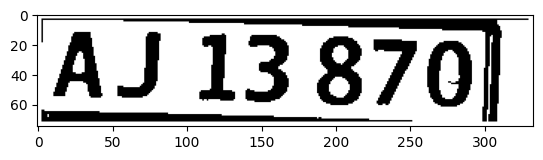

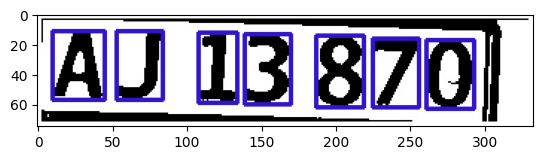

In [49]:
char = segment_characters(plate_out)

# CNN

## Create fit parameters

In [50]:
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
train_generator = train_datagen.flow_from_directory(
        'data/data/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        'data/data/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28        batch_size=1,
        class_mode='categorical')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


## Model

In [51]:
model = Sequential()
model.add(Conv2D(32, (24,24), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(Conv2D(32, (20,20), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(Conv2D(32, (20,20), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.00001), metrics=['accuracy'])

c:\Users\Peter\Documents\GitHub\car-license-plate-detection\.venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## A custom training callback

In [52]:
class stop_training_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc') > 0.992):
      self.model.stop_training = True

## Create logs

In [53]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## Model training

In [54]:
#CAREFUL THIS IS A LARGE PROCESS
batch_size = 1
callbacks = [tensorboard_callback, stop_training_callback()]
model_history = model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      validation_steps = validation_generator.samples // batch_size,
      epochs = 80)

#, callbacks=callbacks)

Epoch 1/80
864/864 [==============================] - 7s 8ms/step - loss: 3.5325 - accuracy: 0.0683 - val_loss: 3.3647 - val_accuracy: 0.1481
Epoch 2/80
864/864 [==============================] - 6s 7ms/step - loss: 3.1711 - accuracy: 0.2199
Epoch 3/80
864/864 [==============================] - 6s 7ms/step - loss: 2.5967 - accuracy: 0.3345
Epoch 4/80
864/864 [==============================] - 6s 7ms/step - loss: 2.0918 - accuracy: 0.4572
Epoch 5/80
864/864 [==============================] - 6s 7ms/step - loss: 1.7525 - accuracy: 0.5058
Epoch 6/80
864/864 [==============================] - 7s 8ms/step - loss: 1.5099 - accuracy: 0.6053
Epoch 7/80
864/864 [==============================] - 7s 8ms/step - loss: 1.2645 - accuracy: 0.6678
Epoch 8/80
864/864 [==============================] - 7s 8ms/step - loss: 1.0960 - accuracy: 0.6979
Epoch 9/80
864/864 [==============================] - 6s 7ms/step - loss: 1.0212 - accuracy: 0.6968
Epoch 10/80
864/864 [==============================] - 6s 

## Tensorboard

In [ ]:
#!kill 6360
%load_ext tensorboard
%tensorboard --logdir logs/fit

# Results

## Print plate number

In [56]:
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28))
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = np.argmax(model.predict(img)[0]) #predicting the class np.argmax(model.predict(x_test), axis=-1)     classes_ = np.argmax(y_, axis = 1)
        character = dic[y_] #
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

1/1 [==============================] - 0s 17ms/step
AJ13870


## Show prediction

1/1 [==============================] - 0s 16ms/step


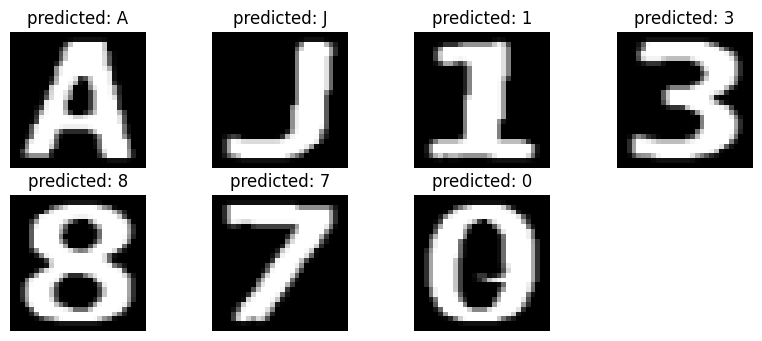

In [58]:
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28))
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()